# Data exploration

In [1]:
# Imports
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from src.helpers.path import DATA_PATH

In [2]:
# Set some constants for plotting
plt.rcParams["figure.figsize"] = (20, 10)

In [3]:
train_data = pd.read_csv(DATA_PATH / "train.csv", parse_dates=["start_time"])
train_data.head()

,start_time,hydro,micro,thermal,wind,river,total,y,sys_reg,flow
0,2019-01-09 14:10:00,1591.839,141.928,11.5,74.428,0.0,1819.695,341.330021,10.0,-4417.4
1,2019-01-09 14:15:00,1591.839,141.928,11.5,74.428,0.0,1819.695,330.114330,10.0,-4417.4
2,2019-01-09 14:20:00,1591.839,141.928,11.5,74.428,0.0,1819.695,323.877221,10.0,-4417.4
3,2019-01-09 14:25:00,1591.839,141.928,11.5,74.428,0.0,1819.695,296.438463,10.0,-4417.4
4,2019-01-09 14:30:00,1591.839,141.928,11.5,74.428,0.0,1819.695,269.097132,10.0,-4417.4


In [4]:
# Move y to last column
columns = train_data.columns.to_list()
columns.remove("y")
columns.append("y")
train_data = train_data[columns]

# Add simple preprocessing
This allows us to see changes when data is preprocessed

In [5]:
# Copy train_data, to allow comparisons later
processed_data = train_data.copy()

## Clamp y-values

In [6]:
# Trial-and-error trying to find correct distribution of removals between top and bottom
# We are only allowed to remove 1% of the values
processed_data.y.describe(percentiles=[
    0.001, 0.0025, 0.005, 0.0075, 0.01, 0.02, 0.05, 0.95, 0.98, 0.99, 0.9925, 0.995, 0.9975, 0.999
])

count     225088.000000
mean           8.907921
std          320.262539
min        -1579.680903
0.1%        -997.559730
0.25%       -876.826439
0.5%        -802.461468
0.75%       -760.869340
1%          -730.619618
2%          -639.141650
5%          -451.001161
50%          -11.282351
95%          495.173041
98%          809.519772
99%         1098.603233
99.25%      1452.095430
99.5%       1744.781387
99.75%      1965.409902
99.9%       2249.140779
max         2956.333317
Name: y, dtype: float64

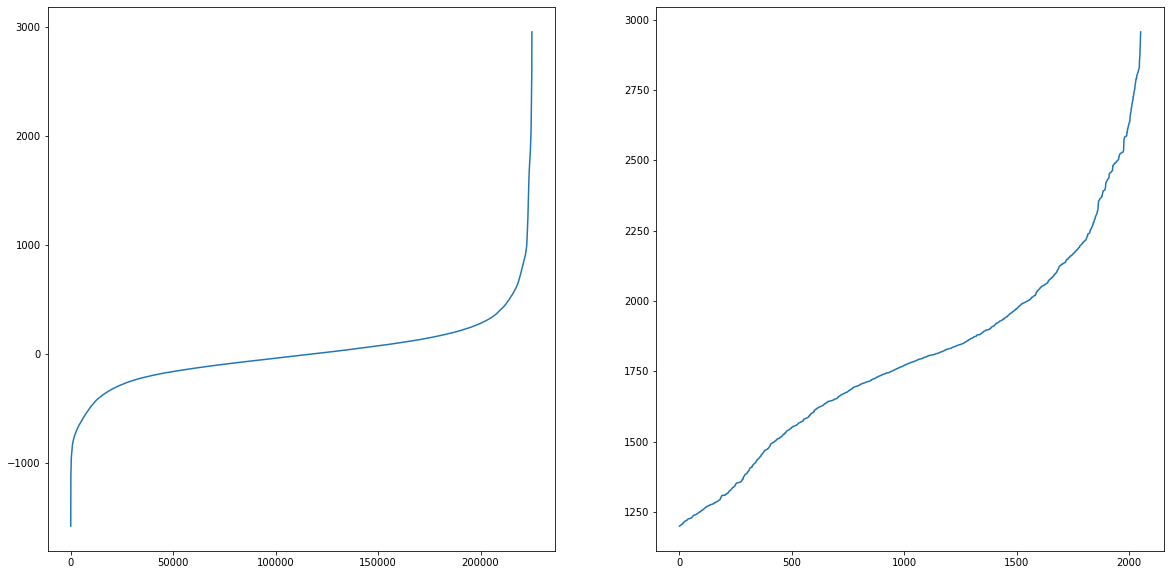

In [7]:
fig, ax = plt.subplots(1, 2)
ax[0].plot(processed_data.y.sort_values().values)
ax[1].plot(processed_data[processed_data.y > 1200].y.sort_values().values)

<AxesSubplot:>

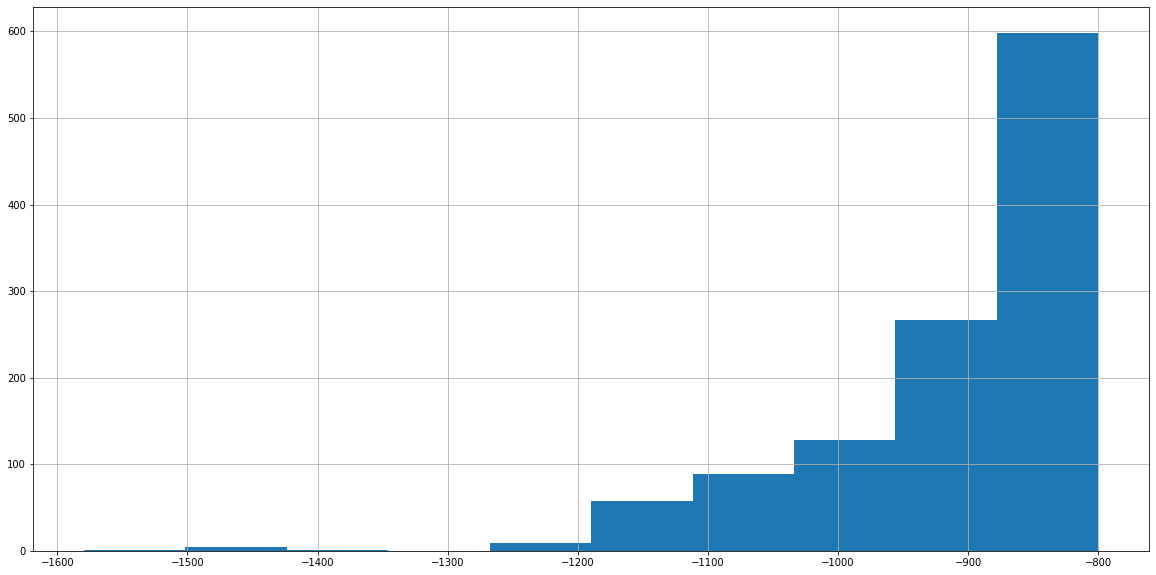

In [8]:
processed_data[processed_data.y < -800].y.hist()

<AxesSubplot:>

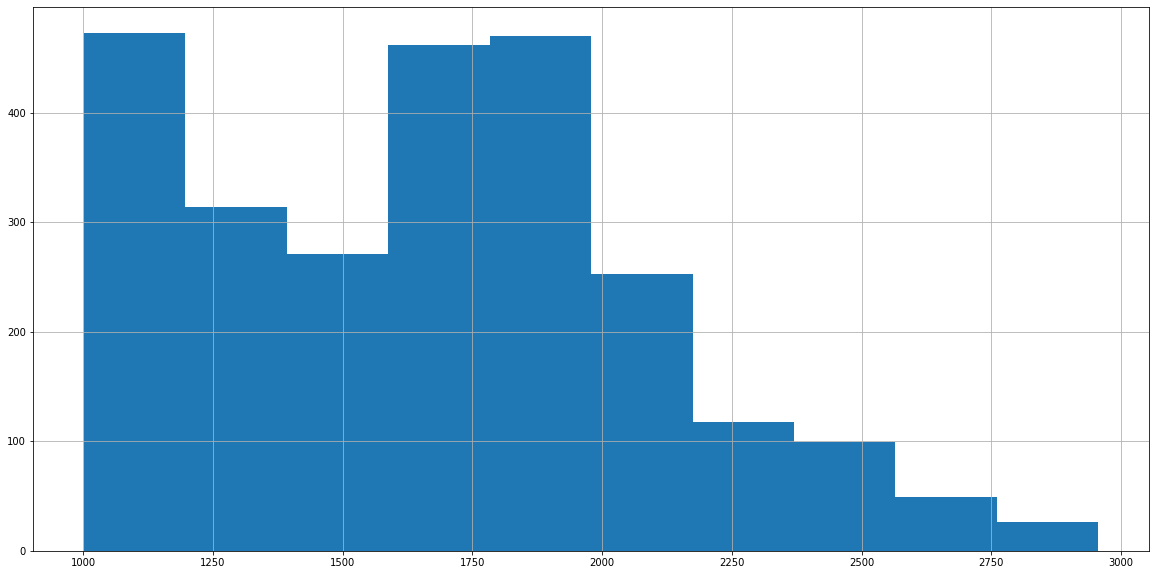

In [9]:
processed_data[processed_data.y > 1000].y.hist()

Some things to note:
- The difference between min -> 0.1% is quite large, but the difference from there and out is smaller.
- The difference at highest values are pretty stable and "sloping", but with a top around 1750, which we may want to remove

We want to remove values below -1000 and above around 1370

In [10]:
# See percentage of values we will clamp (must be below 0.01)
bottom_cutoff = -1000
top_cutoff = 1370
bottom_removed = processed_data[processed_data.y < bottom_cutoff].y.count()
top_removed = processed_data[processed_data.y > top_cutoff].y.count()
total_elements = processed_data.y.count()
print(f"Top percentage removed:    {top_removed * 100 / total_elements:.2f}%")
print(f"Bottom percentage removed: {bottom_removed * 100 / total_elements:.2f}%")
print(f"Total percentage removed:  {(top_removed + bottom_removed) * 100 / total_elements:.2f}%")

Top percentage removed:    0.79%
Bottom percentage removed: 0.10%
Total percentage removed:  0.88%


In [11]:
# Actually clamp values
processed_data.y = processed_data.y.clip(lower=bottom_cutoff, upper=top_cutoff)

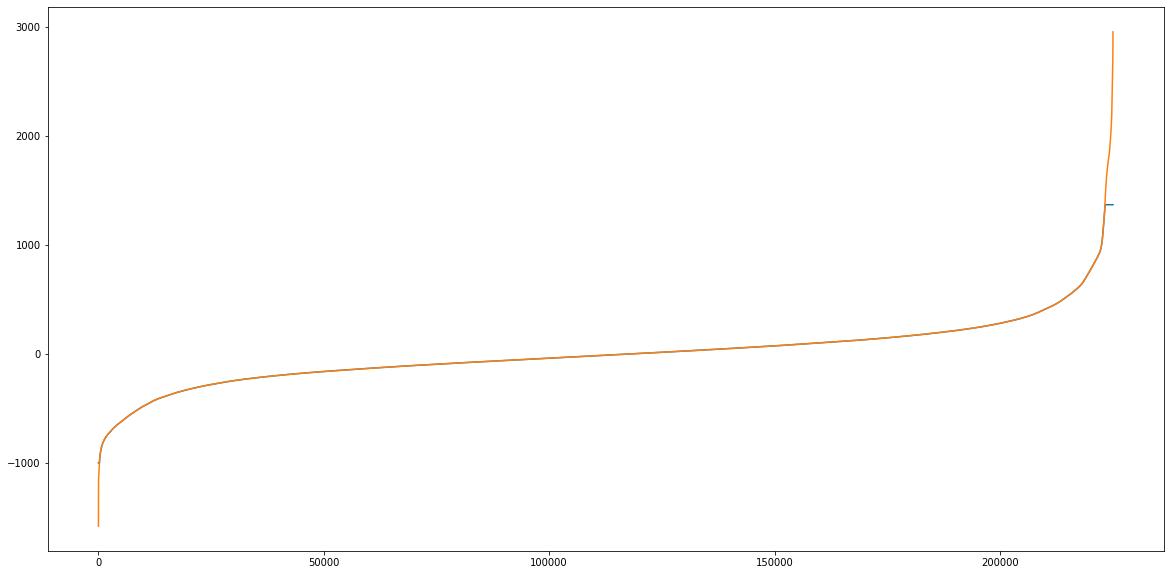

In [12]:
# Compare old and new y-values
plt.plot(processed_data.y.sort_values().values, label="Processed data")
plt.plot(train_data.y.sort_values().values, label="Unprocessed data")

In [13]:
# Describe the new data
train_data.describe()

,hydro,micro,thermal,wind,river,total,sys_reg,flow,y
count,225088.000000,225088.000000,225088.000000,225088.000000,225088.0,225088.000000,225088.000000,225088.000000,225088.000000
mean,1888.334127,224.189826,21.803497,55.703266,0.0,2190.031963,-8.284305,-1999.055081,8.907921
std,401.000305,58.559855,3.579229,47.053033,0.0,444.077730,43.748315,1311.682286,320.262539
min,683.438000,80.371000,0.000000,0.000000,0.0,849.732000,-828.000000,-5541.200000,-1579.680903
25%,1625.029000,185.017000,22.100000,15.704000,0.0,1916.523000,0.000000,-2996.700000,-142.226700
50%,1933.916000,225.938000,22.100000,41.848000,0.0,2248.874000,0.000000,-1953.700000,-11.282351
75%,2175.595000,269.558000,24.100000,88.723000,0.0,2497.792000,0.000000,-906.900000,127.454943
max,2995.524000,349.271000,25.700000,176.000000,0.0,3351.974000,474.000000,723.400000,2956.333317


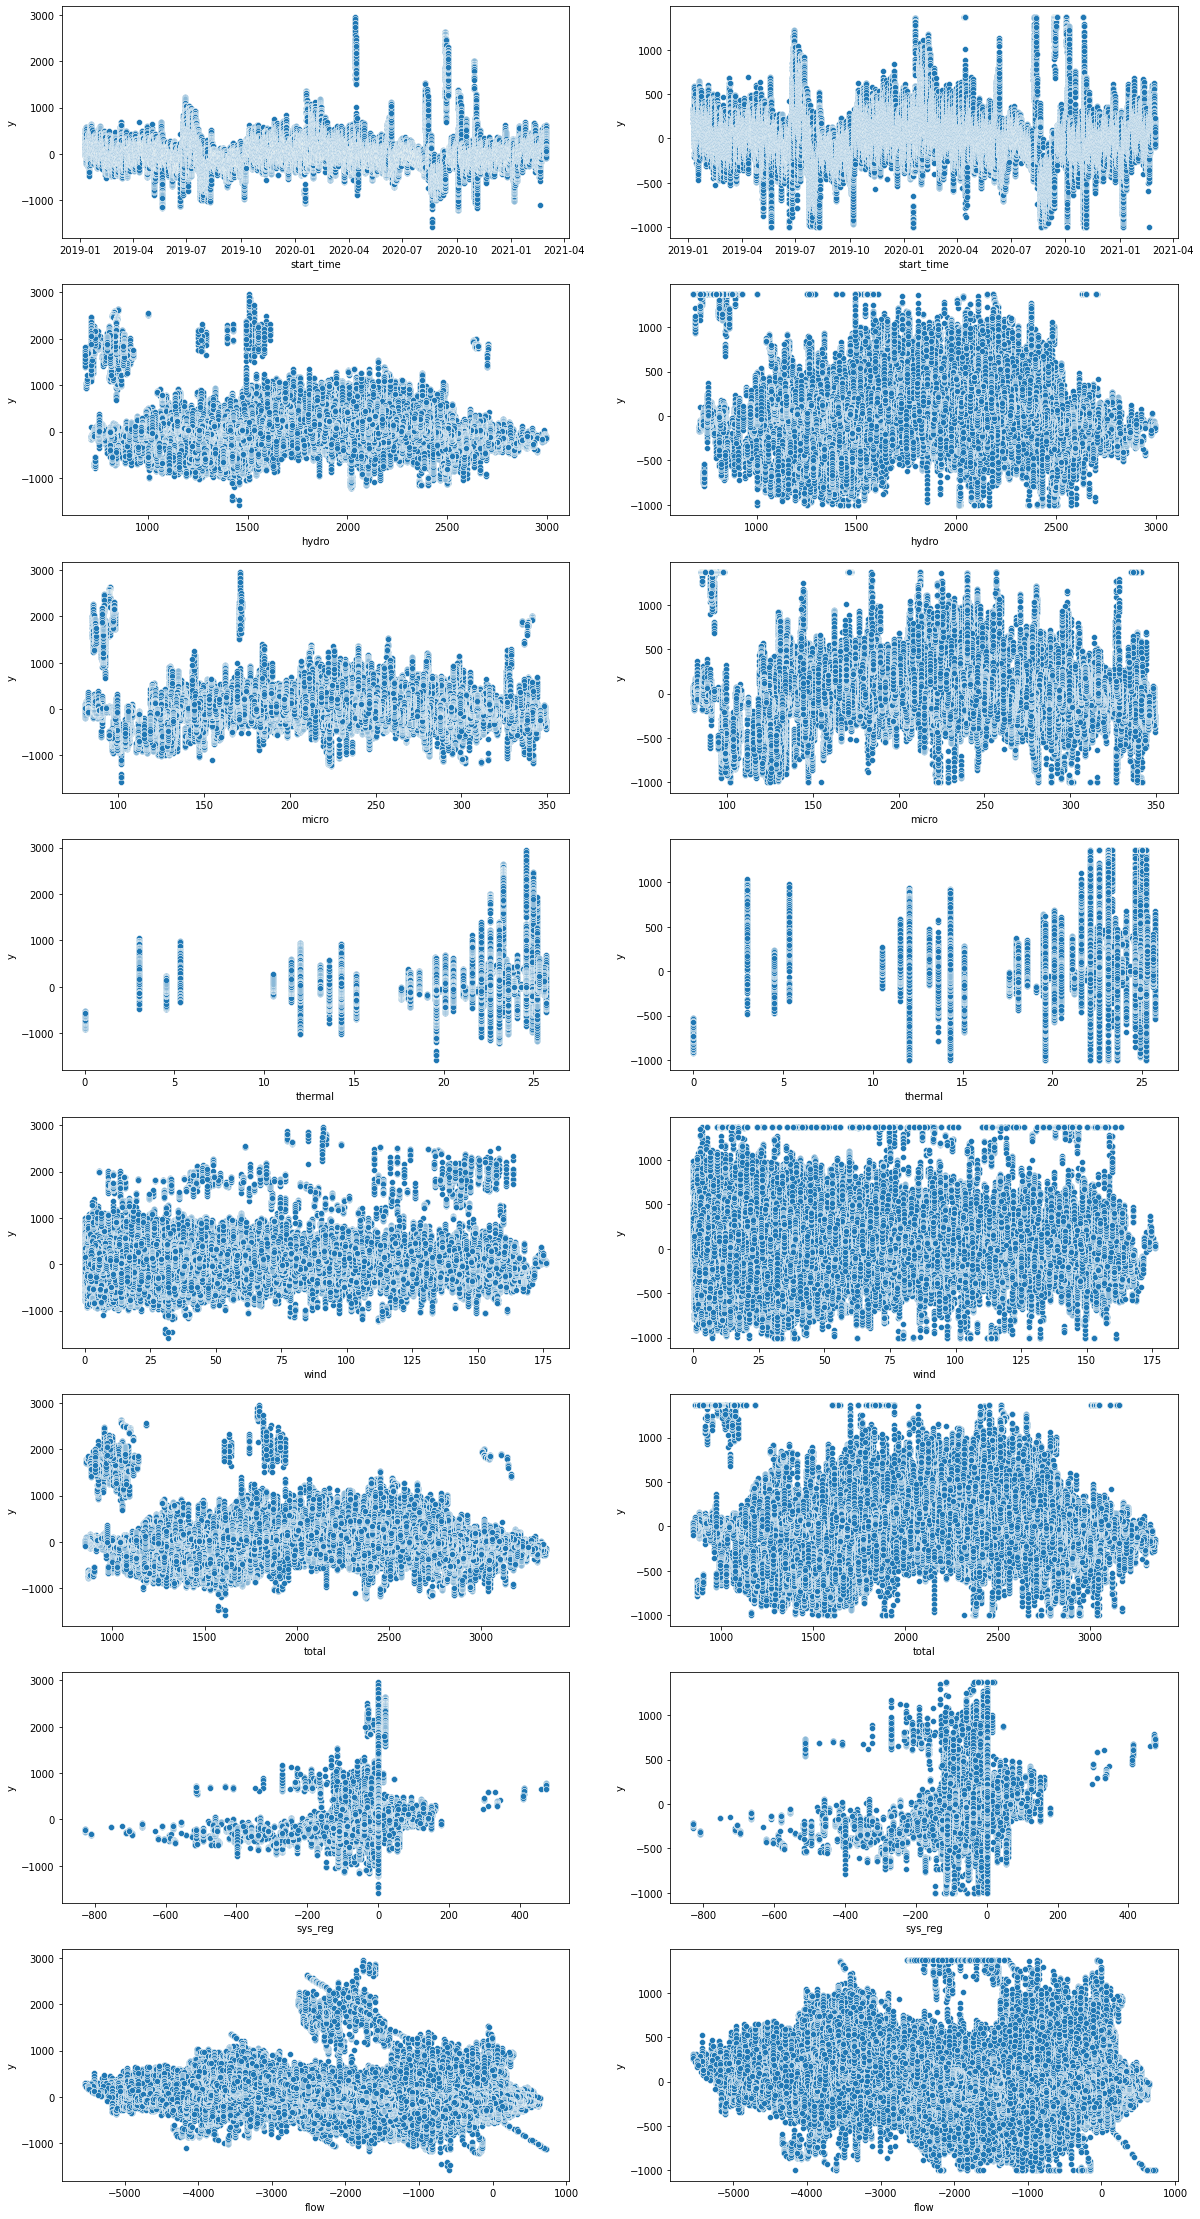

In [14]:
# Plot changes in correlation
fig, axes = plt.subplots(nrows=8, ncols=2, figsize=(20, 40))

for i, col in enumerate(train_data.drop(["y", "river"], axis=1).columns):
    sns.scatterplot(x=col, y="y", data=train_data[[col, "y"]], ax=axes[i][0])
    sns.scatterplot(x=col, y="y", data=processed_data[[col, "y"]], ax=axes[i][1])
